In [4]:
#Bring in an ungodly number of imports, plot size, plot style, inline 'magic'
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import sklearn.datasets as datasets
import scipy.stats as stats
from ipywidgets import *
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.rc("figure", figsize=(9, 7))
sns.set_style('whitegrid')
%matplotlib inline

In [5]:
# Set the initial url to reddit home, get the response url, include custom user agent
# assign reposse tex to variable 'URL', print the status code to make sure we're getting 
# a 200 response code. add html to bsoup and assign that to variable 'soup'
url = "https://www.reddit.com"

#response = requests.get(url)
response = requests.get(url, headers = {'User-agent': 'moose'})
html = response.text
print(response.status_code)
soup = BeautifulSoup(html, 'lxml')

200


In [6]:
urls = []
count = 0
while (count < 50):
    # This will loop for # in while arg, its finds the text in the 'next' button, strips
    # out the part after 'after =', iterates url_count by 25 and appends both ot text creating
    # the 'next' urls.  Then theat next url is fed back into beautiful soup
    result_list = soup.body.find('span', {'class':'next-button'})
    next_url = result_list.find('a')['href']

    after = str(next_url.split('after=')[1])
    url_count = str(25*(1+count))
    next_url = "https://www.reddit.com/?count=" + url_count + "&after=" + after
    
    count = count + 1
    urls.append(next_url)
    
    response = requests.get(next_url, headers = {'User-agent': 'moose'})
    html = response.text
    soup = BeautifulSoup(html, 'lxml')

urls

['https://www.reddit.com/?count=25&after=t3_7zp57u',
 'https://www.reddit.com/?count=50&after=t3_7zo7mp',
 'https://www.reddit.com/?count=75&after=t3_7zob2r',
 'https://www.reddit.com/?count=100&after=t3_7znkul',
 'https://www.reddit.com/?count=125&after=t3_7zmz5f',
 'https://www.reddit.com/?count=150&after=t3_7znd6d',
 'https://www.reddit.com/?count=175&after=t3_7zni9y',
 'https://www.reddit.com/?count=200&after=t3_7zp5fz',
 'https://www.reddit.com/?count=225&after=t3_7zp0z3',
 'https://www.reddit.com/?count=250&after=t3_7zo31m',
 'https://www.reddit.com/?count=275&after=t3_7zn75j',
 'https://www.reddit.com/?count=300&after=t3_7zo8yl',
 'https://www.reddit.com/?count=325&after=t3_7zj4m9',
 'https://www.reddit.com/?count=350&after=t3_7znci5',
 'https://www.reddit.com/?count=375&after=t3_7znpaf',
 'https://www.reddit.com/?count=400&after=t3_7zntcw',
 'https://www.reddit.com/?count=425&after=t3_7znfz3',
 'https://www.reddit.com/?count=450&after=t3_7znlxv',
 'https://www.reddit.com/?count

In [7]:
# homepage if inseted into the begining of the list
urls.insert(0,'https://www.reddit.com')
urls

['https://www.reddit.com',
 'https://www.reddit.com/?count=25&after=t3_7zp57u',
 'https://www.reddit.com/?count=50&after=t3_7zo7mp',
 'https://www.reddit.com/?count=75&after=t3_7zob2r',
 'https://www.reddit.com/?count=100&after=t3_7znkul',
 'https://www.reddit.com/?count=125&after=t3_7zmz5f',
 'https://www.reddit.com/?count=150&after=t3_7znd6d',
 'https://www.reddit.com/?count=175&after=t3_7zni9y',
 'https://www.reddit.com/?count=200&after=t3_7zp5fz',
 'https://www.reddit.com/?count=225&after=t3_7zp0z3',
 'https://www.reddit.com/?count=250&after=t3_7zo31m',
 'https://www.reddit.com/?count=275&after=t3_7zn75j',
 'https://www.reddit.com/?count=300&after=t3_7zo8yl',
 'https://www.reddit.com/?count=325&after=t3_7zj4m9',
 'https://www.reddit.com/?count=350&after=t3_7znci5',
 'https://www.reddit.com/?count=375&after=t3_7znpaf',
 'https://www.reddit.com/?count=400&after=t3_7zntcw',
 'https://www.reddit.com/?count=425&after=t3_7znfz3',
 'https://www.reddit.com/?count=450&after=t3_7znlxv',
 'ht

In [69]:
# function to be used later.  Generates subreddits
def get_subs(stuff):
    for element in stuff:
        try:
            subs.append(element.text)
        except:
            subs.append('NULL')
    return subs 

In [9]:
# function to be used later.  Generates post titles
def get_titles(stuff):
    for element in stuff:
        try:
            titles.append(element.text)
        except:
            titles.append('NULL')
    return titles  

In [10]:
# function to be used later.  Generates comments
def get_comms(stuff):
    for element in stuff:
        try:
            comms.append(element.text)
        except:
            comms.append('NULL')
    return comms  

In [11]:
# function to be used later.  Generates post times
def get_times(stuff):
    for element in stuff:
        try:
            times.append(element.text)
        except:
            times.append('NULL')
    return times 

In [12]:
# This loop creates 4 lists.  For each i in urls (generated prevously) the previously created
# functions are called and that page's information is extracted.  At the bottom of the look 
# I keep updating bsoup with a new url
titles = []
subs = []
comms = []
times = []
count = 0

for i in urls:
    response = requests.get(i, headers = {'User-agent': 'moose'})
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    
    #call functions
    all_td = soup.find_all('a',{"data-event-action": "title"}) 
    get_titles(all_td)
    all_subs = soup.find_all('a',{'class': 'subreddit hover may-blank'})
    get_subs(all_subs)
    all_comms = soup.find_all('a',{"data-event-action": 'comments'})
    get_comms(all_comms)
    all_times = soup.find_all('time',{'class': 'live-timestamp'})
    get_times(all_times)
    
    #reset soup for new link
    response = requests.get(i, headers = {'User-agent': 'moose'})
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    time.sleep(2)
    count = count + 1
    print (count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


In [1051]:
# Turn lists from above function into dataframe and set headers
r_posts = pd.DataFrame({'Title':titles,'Comments':comms,'Time': times, 'subreddit':subs})
r_posts = r_posts[['Title', 'Comments','Time','subreddit' ]]

In [1052]:
# Remove nulls (none in this case, but there were some empty comments previously)
r_posts['Comments'].dropna(axis=0, how='any')
r_posts['Comments'].isnull().sum()

0

In [ ]:
# Previously did EDA using .shape, .describe. .dtypes .value_counts 
# on the df and individual series

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [1055]:
# Save the csv to computer in case any madness occurs and the data is lost
path = '\jakerattner\documents\project-3\data.csv'
r_posts.to_csv(path, encoding='utf-8')

In [1056]:
# There is some data cleaning here.  I couldn't quite get comments clean
r_posts['Comments'] = r_posts['Comments'].str.replace(' comments','')
r_posts['Comments'] = r_posts['Comments'].str.replace('comment','')
r_posts['Comments'] = r_posts['Comments'].str.replace(' ','')
r_posts['Time'] = r_posts['Time'].str.replace(' hours ago','')
r_posts['Time'] = r_posts['Time'].str.replace(' minutes ago','')

In [1057]:
# This is ultimately what I used to clean up comments.  It turned them into floats
r_posts['Comments'] = pd.to_numeric(r_posts['Comments'], errors='coerce')
r_posts.head()

,Title,Comments,Time,subreddit
0,Change My Mind,2273.0,2,r/funny
1,Immunity dog,183.0,3,r/wholesomememes
2,Violent video games actually reduces violence ...,1986.0,3,r/gaming
3,"Scranton, WHAT?: The Claymation City",152.0,4,r/DunderMifflin
4,"TIL Harriet Tubman, in addition to organizing ...",431.0,5,r/todayilearned


In [1058]:
r_posts['Comments'].dtypes

dtype('float64')

In [1059]:
# Just taking a look because I'm using it as a way to make new binary column
r_posts['Comments'].median()

86.0

In [1060]:
# Creates a new binary variable based on whether the comments are above or below the median
r_posts['high_low'] = np.where(r_posts['Comments']>=r_posts['Comments'].median(), "1", "0")

In [1062]:
#function to remove and punctuation from the text entered
def remove_punctuation(text):
    lower = text.lower()   #makes all text lowercase
    exclude = set(string.punctuation)    #can tell it to exclude punctuation marks. See above library link
    return "".join(ch for ch in lower if ch not in exclude)  #will return the string of text if the character for each character in lower and is not in the excluded puncuation

In [1063]:
# remove punctuation from the title series with the remove_punctuation function
r_posts['Title'] = r_posts['Title'].apply(remove_punctuation)

In [1064]:
# Stemming function is used to simplify the text to its more basic root
stemmer = PorterStemmer()
def stems(string):
    string = string.split(' ')
    temp = ""
    for i in string:
        temp += (stemmer.stem(i) + " ")
    return temp

In [1065]:
# Stem function applied to titles
r_posts['Title'] = r_posts['Title'].apply(stems)

In [1066]:
# Change type of new column
r_posts['high_low'] = r_posts['high_low'].astype(int)

- Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title.
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

# Creating a RandomForest with Subreddit

In [1067]:
# assign high/low to dep and subreddit to indep, instantiate countvectorizer with englist as stop
# fit and transform, set x to dense to binary and finally train test split 30%
# 
y = r_posts['high_low']
X = r_posts['subreddit']

cvec = CountVectorizer(stop_words = 'english') 

X  = pd.DataFrame(cvec.fit_transform(X).todense(),
             columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [1068]:
# instantiate, fit with training data
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [1069]:
# train score
clf.score(X_train, y_train)

0.88677130044843044

In [1070]:
# test score
clf.score(X_test, y_test)

0.83289817232375984

In [1071]:
#predictive baseline
base_score = np.mean(y_test)
base_score

0.49869451697127937

In [1072]:
# make/print predictions
predictions = clf.predict(X_test)  # we need to get our models predictions based on the x_test data
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0,

In [1073]:
len(predictions)

383

In [1074]:
# create dataframe of matrix and add to variable conmat
conmat = pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_High(1)', 'predicted_low(0)'], index=['is_High(1)', 'is_Low(0)'])

In [1075]:
conmat

,predicted_High(1),predicted_low(0)
is_High(1),167,25
is_Low(0),39,152


In [1076]:
print("\nClassification Report:\n",classification_report(y_test, predictions))
# recall is sensetivity, shows confusion matrix scoring


Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.87      0.84       192
          1       0.86      0.80      0.83       191

avg / total       0.83      0.83      0.83       383



In [1077]:
#Tells us the probablity of a Reddit will be correctly identified in the class its assigned
clf_y_score = clf.predict_proba(X_test)[:, 1] #[:,1] is formatting the output
clf_y_score

array([ 0.23508264,  1.        ,  0.66355241,  0.3       ,  0.        ,
        0.        ,  0.705     ,  0.1       ,  0.42723242,  0.705     ,
        0.1       ,  0.        ,  0.23508264,  0.8       ,  0.4684384 ,
        1.        ,  0.75940476,  0.4       ,  0.82142857,  0.8       ,
        1.        ,  1.        ,  0.8       ,  0.4       ,  0.8       ,
        0.9       ,  0.        ,  1.        ,  1.        ,  0.1       ,
        0.4       ,  0.23508264,  0.35460317,  0.9       ,  0.69359933,
        0.3       ,  0.57666667,  0.66355241,  0.3       ,  1.        ,
        1.        ,  0.66355241,  0.4       ,  0.4       ,  1.        ,
        0.        ,  0.1       ,  1.        ,  1.        ,  0.4       ,
        0.53952381,  1.        ,  0.53952381,  0.4       ,  0.4       ,
        0.1       ,  0.1       ,  0.2       ,  0.6       ,  0.25335942,
        0.23508264,  1.        ,  0.9       ,  1.        ,  0.57666667,
        0.4       ,  0.30916667,  0.9       ,  1.        ,  0.69

In [1078]:
print(roc_auc_score(y_test, clf_y_score))
#looks just at the rate of true positives

0.904654777487


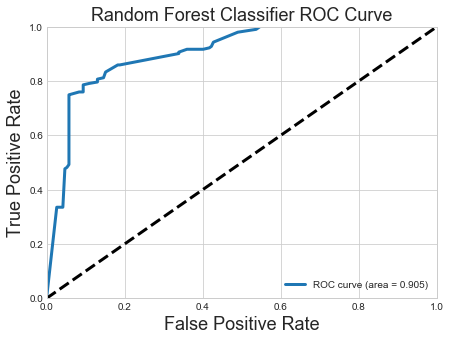

In [1079]:
# visualization of area under the curve (blue line).  Shows the 90% coverage
clf_FPR = dict()
clf_TPR = dict()
clf_ROC_AUC = dict()

clf_FPR[1], clf_TPR[1], _ = roc_curve(y_test, clf_y_score)
clf_ROC_AUC[1] = auc(clf_FPR[1], clf_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(clf_FPR[1], clf_TPR[1], label='ROC curve (area = %0.3f)' % clf_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [1081]:
#determine most important features/words in our model
clf_feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
print(clf_feature_importances.head(10))
clf_feature_importances.head(10).sum()

                    importance
askreddit             0.017220
worldnews             0.015030
aww                   0.014883
chibears              0.013142
pics                  0.013014
whatcouldgowrong      0.011818
fireemblemheroes      0.011143
cattaps               0.010746
whitepeopletwitter    0.009202
shittylifeprotips     0.008800


importance    0.124997
dtype: float64

# Creating a RandomForest with Subreddit, and "Cat" and "Dog" variables

In [ ]:
# Here I'm basically rerunning all of the same code, but first adding 2 extra features/series
# 'Dog' = whether or not do is in the title and 'cat'...same thing, but with cat

In [1082]:
#creates the cat binary series
cat_list= []
word = 'cat'
for row in r_posts.Title:  
    if word.lower() in row:
        cat_list.append(1)
    else:
        cat_list.append(0)

In [1083]:
# Turn cat list into catafram and count_values to make sure it looks ok
r_posts['cat'] = pd.DataFrame(cat_list)
r_posts['cat'].value_counts()

0    1258
1      17
Name: cat, dtype: int64

In [1084]:
#creates the dog binary series
dog_list= []
word = 'dog'
for row in r_posts.Title:  
    if word.lower() in row:
        dog_list.append(1)
    else:
        dog_list.append(0)

In [1085]:
# Turn dog list into catafram and count_values to make sure it looks ok
r_posts['dog'] = pd.DataFrame(dog_list)
r_posts['dog'].value_counts()

0    1238
1      37
Name: dog, dtype: int64

In [1086]:
y = r_posts['high_low']
X = r_posts['subreddit']

cvec = CountVectorizer(stop_words = 'english') 

X  = pd.DataFrame(cvec.fit_transform(X).todense(),
             columns=cvec.get_feature_names())

In [1087]:
p = X
#this is a weird thing I'm trying so that later on in the section 
#where I add title vectors, I can easily a it to X
#seem to have worked

In [1088]:
# appends X variable with the new cat and dog binary columns
X['cat'] = r_posts['cat']
X['dog'] = r_posts['dog']
# after this I rereun all the same code from the previous model

In [1089]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [1090]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [1091]:
clf.score(X_train, y_train)

0.89798206278026904

In [1092]:
clf.score(X_test, y_test)

0.80678851174934729

In [1093]:
predictions = clf.predict(X_test)  # we need to get our models predictions based on the x_test data
predictions

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1,

In [1094]:
len(predictions)

383

In [1095]:
conmat = pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_High(1)', 'predicted_low(0)'], index=['is_High(1)', 'is_Low(0)'])

In [1096]:
conmat

,predicted_High(1),predicted_low(0)
is_High(1),161,28
is_Low(0),46,148


In [1097]:
print("\nClassification Report:\n",classification_report(y_test, predictions))
# recall is sensetivity


Classification Report:
              precision    recall  f1-score   support

          0       0.78      0.85      0.81       189
          1       0.84      0.76      0.80       194

avg / total       0.81      0.81      0.81       383



In [1098]:
#Tells us the probablity of a Reddit will be correctly identified in the class its assigned
clf_y_score = clf.predict_proba(X_test)[:, 1] #[:,1] is formatting the output
clf_y_score

array([ 0.82857143,  0.67857143,  0.        ,  0.31286176,  0.38666667,
        0.3452381 ,  1.        ,  0.65      ,  0.73571429,  0.        ,
        0.86666667,  1.        ,  0.        ,  0.        ,  0.52186647,
        0.86666667,  0.3452381 ,  0.5952381 ,  1.        ,  0.86666667,
        1.        ,  0.36727328,  0.        ,  0.1       ,  0.71115152,
        1.        ,  0.        ,  0.1       ,  1.        ,  0.82857143,
        0.96666667,  0.24166667,  0.0952381 ,  0.46404762,  0.        ,
        1.        ,  0.        ,  1.        ,  0.3452381 ,  0.        ,
        1.        ,  1.        ,  0.67142857,  0.16666667,  0.52186647,
        1.        ,  0.23188845,  0.        ,  0.673557  ,  0.95      ,
        0.63260989,  0.24166667,  0.8       ,  0.07857143,  0.        ,
        0.        ,  1.        ,  0.        ,  0.3452381 ,  0.9       ,
        0.3452381 ,  0.82857143,  0.        ,  1.        ,  0.        ,
        0.3452381 ,  0.0952381 ,  1.        ,  0.3452381 ,  0.34

In [1099]:
print(roc_auc_score(y_test, clf_y_score))
#looks just at the rate of true positives

0.892352588229


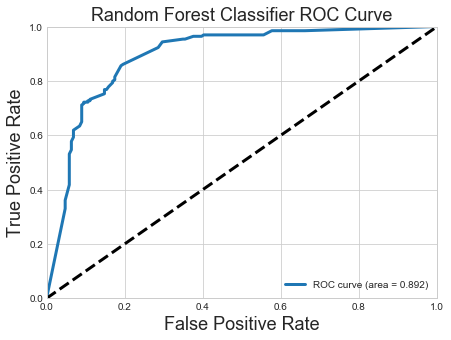

In [1100]:
clf_FPR = dict()
clf_TPR = dict()
clf_ROC_AUC = dict()

clf_FPR[1], clf_TPR[1], _ = roc_curve(y_test, clf_y_score)
clf_ROC_AUC[1] = auc(clf_FPR[1], clf_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(clf_FPR[1], clf_TPR[1], label='ROC curve (area = %0.3f)' % clf_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [1101]:
#determine most important features/words in our model
clf_feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
print(clf_feature_importances.head(10))
clf_feature_importances.head(10).sum()

                  importance
dog                 0.018013
worldnews           0.015411
chibears            0.014538
whatcouldgowrong    0.014301
pics                0.013407
askreddit           0.012679
documentaries       0.012491
blunderyears        0.011063
creepy              0.010721
socialism           0.010370


importance    0.132994
dtype: float64

# Creating a RandomForest with Subreddit, "Cat"/"Dog" and Title CountVectorized Features

In [1102]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

In [1103]:
# Count Vectorize with 'title'
y = r_posts['high_low']
X = r_posts['Title']

cvec = CountVectorizer(stop_words = 'english') 

X  = pd.DataFrame(cvec.fit_transform(X).todense(),
             columns=cvec.get_feature_names())

In [1104]:
# append previously vectorized subreddits (this is what I described as weird earlier)
X = pd.concat([X, p,], axis=1)

In [1105]:
X = pd.concat([X, r_posts['cat']], axis=1) # add cat to X

In [1106]:
X = pd.concat([X, r_posts['dog']], axis=1) # add dog to x
# then rerun all RFC code used previously after this cell

In [1107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [1108]:
print(cvecdata)

  (0, 269)	1
  (0, 913)	1
  (1, 434)	1
  (1, 730)	1
  (2, 72)	1
  (2, 283)	1
  (2, 595)	1
  (2, 1170)	1
  (2, 1527)	1
  (2, 1532)	1
  (2, 1533)	1
  (3, 292)	1
  (3, 297)	1
  (3, 1257)	1
  (4, 36)	1
  (4, 49)	1
  (4, 74)	1
  (4, 79)	1
  (4, 132)	1
  (4, 256)	1
  (4, 293)	1
  (4, 462)	1
  (4, 577)	1
  (4, 658)	1
  (4, 808)	1
  :	:
  (1270, 434)	1
  (1270, 784)	1
  (1270, 1435)	1
  (1271, 77)	1
  (1271, 189)	1
  (1271, 1024)	1
  (1271, 1181)	1
  (1271, 1198)	1
  (1271, 1337)	1
  (1271, 1467)	1
  (1272, 121)	1
  (1272, 780)	1
  (1272, 983)	1
  (1272, 1394)	1
  (1272, 1454)	1
  (1273, 1067)	1
  (1273, 1435)	1
  (1273, 1544)	1
  (1273, 1551)	1
  (1273, 1588)	1
  (1274, 811)	1
  (1274, 879)	1
  (1274, 1326)	1
  (1274, 1344)	1
  (1274, 1476)	1


In [1109]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [1110]:
clf.score(X_train, y_train)

0.99439461883408076

In [1111]:
clf.score(X_test, y_test)

0.90600522193211486

In [1112]:
predictions = clf.predict(X_test)  # we need to get our models predictions based on the x_test data
predictions

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0,

In [1113]:
len(predictions)

383

In [1114]:
conmat = pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_High(1)', 'predicted_low(0)'], index=['is_High(1)', 'is_Low(0)'])

In [1115]:
conmat

,predicted_High(1),predicted_low(0)
is_High(1),185,12
is_Low(0),24,162


In [1116]:
print("\nClassification Report:\n",classification_report(y_test, predictions))
# recall is sensetivity
# Model evaluation lecture: https://git.generalassemb.ly/DSI-EAST-2/4.04-model-evaluation-i/blob/master/4.04-model-evaluation-i.pdf


Classification Report:
              precision    recall  f1-score   support

          0       0.89      0.94      0.91       197
          1       0.93      0.87      0.90       186

avg / total       0.91      0.91      0.91       383



In [1117]:
#Tells us the probablity of a Reddit will be correctly identified in the class its assigned
clf_y_score = clf.predict_proba(X_test)[:, 1] #[:,1] is formatting the output
clf_y_score

array([ 0. ,  0. ,  1. ,  0.9,  0.4,  1. ,  0. ,  1. ,  1. ,  0.8,  0. ,
        0.1,  1. ,  1. ,  0.7,  0.9,  0.1,  0.6,  0. ,  1. ,  0.4,  0.9,
        0.1,  1. ,  0.9,  0.9,  1. ,  0.9,  0. ,  1. ,  0.4,  0. ,  0.9,
        0.1,  0.2,  0.9,  0.5,  0.8,  0. ,  0. ,  1. ,  1. ,  0.2,  0.8,
        0.9,  0.1,  0.2,  0.7,  0.9,  0.1,  1. ,  0.9,  0. ,  0. ,  1. ,
        0.5,  0.6,  0.3,  0.1,  1. ,  0.1,  0.9,  0.9,  0.9,  0.1,  1. ,
        0. ,  0. ,  0.1,  0.9,  1. ,  0.9,  0.7,  0. ,  0.4,  0.3,  0.3,
        0.7,  0.4,  0. ,  1. ,  0. ,  0.1,  0.8,  0. ,  1. ,  0.6,  0.1,
        0.1,  0. ,  0. ,  0.1,  0. ,  0.4,  0.1,  0.4,  0.9,  0.1,  0.1,
        0. ,  1. ,  1. ,  0.1,  0.1,  0.1,  1. ,  0. ,  0.6,  1. ,  0. ,
        0.1,  0.5,  0.9,  0. ,  0. ,  0. ,  0.3,  0.4,  0.5,  0.6,  0. ,
        0.9,  0.9,  0. ,  0.4,  0. ,  0. ,  0. ,  1. ,  0. ,  1. ,  0. ,
        1. ,  0.8,  0. ,  0. ,  0.6,  0.7,  0. ,  0.1,  0. ,  0.8,  1. ,
        0.1,  1. ,  0.4,  0.1,  0.6,  1. ,  0.9,  0

In [1118]:
print(roc_auc_score(y_test, clf_y_score))
#looks just at the rate of true positives

0.977157360406


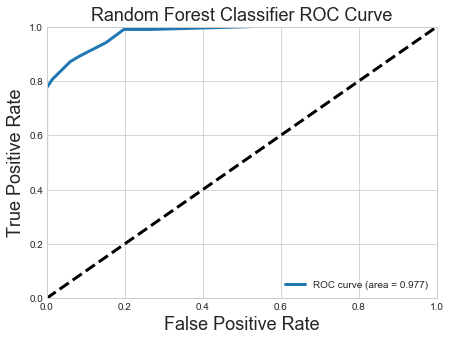

In [1119]:
clf_FPR = dict()
clf_TPR = dict()
clf_ROC_AUC = dict()

clf_FPR[1], clf_TPR[1], _ = roc_curve(y_test, clf_y_score)
clf_ROC_AUC[1] = auc(clf_FPR[1], clf_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(clf_FPR[1], clf_TPR[1], label='ROC curve (area = %0.3f)' % clf_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [1120]:
#determine most important features/words in our model
clf_feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
print(clf_feature_importances.head(10))
clf_feature_importances.head(10).sum()

              importance
ha              0.014649
play            0.010390
best            0.008754
aww             0.007986
prequelmemes    0.007920
worldnews       0.007379
game            0.006472
pics            0.006114
right           0.006076
tree            0.006027


importance    0.081767
dtype: float64

## Repeat the model-building process with a non-tree-based method.

In [1150]:
# I'll use the KNN classifier model.  
# I'm going to want to reimport the X variable to look at the; 
# reddit, the dog/cat and then title
# I run this 3 times 
# First with the subreddit 
# Second with subreddit and dog/cat variables
# Third with the subreddit, dog/cat variables and title vectorized

In [1212]:
#reset x and y to high/low and subreddit
y = r_posts['high_low']
X = r_posts['subreddit']

cvec = CountVectorizer(stop_words = 'english') 

X  = pd.DataFrame(cvec.fit_transform(X).todense(),
             columns=cvec.get_feature_names())

In [1213]:
# Put it into  standard scalar
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)
type(Xs)
Xs

array([[-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.04856429, -0.04856429],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.04856429, -0.04856429],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.04856429, -0.04856429],
       ..., 
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.04856429, -0.04856429],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.04856429, -0.04856429],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.04856429, -0.04856429]])

In [1214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [1215]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [1216]:
knn3 = KNeighborsClassifier( n_neighbors=2,  
                           weights='uniform')
scores = cross_val_score(knn3,  X_train, y_train,  cv=5)
np.mean(scores), np.std(scores)

(0.73094932347726971, 0.038365219285894911)

In [1217]:
knn3 = KNeighborsClassifier( n_neighbors=2,  
                           weights='uniform')
scores = cross_val_score(knn3,  X_test, y_test,  cv=5)
np.mean(scores), np.std(scores)

(0.631784005468216, 0.040320764652695566)

In [1218]:
knn1 = KNeighborsClassifier( n_neighbors=1,  
                           weights='uniform')
scores = cross_val_score(knn1,  X_train, y_train,  cv=5)
np.mean(scores), np.std(scores)

(0.79367016019295078, 0.029460782799662178)

In [1219]:
knn1 = KNeighborsClassifier( n_neighbors=1,  
                           weights='uniform')
scores = cross_val_score(knn1,  X_test, y_test,  cv=5)
np.mean(scores), np.std(scores)

(0.65252904989747107, 0.05259423802535422)

In [1220]:
# Reexamine KNN with dog and cat

In [1221]:
#reset x and y to high/low and subreddit
y = r_posts['high_low']
X = r_posts['subreddit']

cvec = CountVectorizer(stop_words = 'english') 

X  = pd.DataFrame(cvec.fit_transform(X).todense(),
             columns=cvec.get_feature_names())

In [1222]:
X['cat'] = r_posts['cat']
X['dog'] = r_posts['dog']

In [1223]:
# Put it into  standard scalar
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)
type(Xs)
Xs

array([[-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764,  5.78441522],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       ..., 
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832]])

In [1224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [1225]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [1226]:
knn2 = KNeighborsClassifier( n_neighbors=2,  
                           weights='uniform')
scores = cross_val_score(knn3,  X_train, y_train,  cv=5)
np.mean(scores), np.std(scores)

(0.72982537333493624, 0.0094608982820743211)

In [1227]:
knn2 = KNeighborsClassifier( n_neighbors=2,  
                           weights='uniform')
scores = cross_val_score(knn3,  X_test, y_test,  cv=5)
np.mean(scores), np.std(scores)

(0.62392344497607655, 0.027814468139990861)

In [1228]:
knn1 = KNeighborsClassifier( n_neighbors=1,  
                           weights='uniform')
scores = cross_val_score(knn1,  X_train, y_train,  cv=5)
np.mean(scores), np.std(scores)

(0.80157320393348852, 0.019529859283354187)

In [1229]:
knn1 = KNeighborsClassifier( n_neighbors=1,  
                           weights='uniform')
scores = cross_val_score(knn1,  X_test, y_test,  cv=5)
np.mean(scores), np.std(scores)

(0.70495557074504445, 0.044047945724523314)

DOGS CATS AND VECTORIZED TITLES

In [1230]:
#reset x and y to high/low and subreddit
y = r_posts['high_low']
X = r_posts['subreddit']

cvec = CountVectorizer(stop_words = 'english') 

X  = pd.DataFrame(cvec.fit_transform(X).todense(),
             columns=cvec.get_feature_names())

In [1231]:
X = pd.concat([X, p,], axis=1)

In [1232]:
X['cat'] = r_posts['cat']
X['dog'] = r_posts['dog']

In [1233]:
X = pd.concat([X, p,], axis=1)

In [1234]:
# Put it into  standard scalar
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)
type(Xs)
Xs

array([[-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764,  5.78441522],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       ..., 
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832],
       [-0.04856429, -0.04856429, -0.05609927, ..., -0.04856429,
        -0.11624764, -0.17287832]])

In [1235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [1236]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [1240]:
knn5 = KNeighborsClassifier( n_neighbors=2,  
                           weights='uniform')
scores = cross_val_score(knn5,  X_train, y_train,  cv=5)
np.mean(scores), np.std(scores)

(0.76570209026426472, 0.017051939590926251)

In [1241]:
knn5 = KNeighborsClassifier( n_neighbors=2,  
                           weights='uniform')
scores = cross_val_score(knn5,  X_test, y_test,  cv=5)
np.mean(scores), np.std(scores)

(0.62656203445677128, 0.054318981044033661)

In [1242]:
knn1 = KNeighborsClassifier( n_neighbors=1,  
                           weights='uniform')
scores = cross_val_score(knn1,  X_train, y_train,  cv=5)
np.mean(scores), np.std(scores)

(0.80830456342979107, 0.027992081928105747)

In [1243]:
knn1 = KNeighborsClassifier( n_neighbors=1,  
                           weights='uniform')
scores = cross_val_score(knn1,  X_test, y_test,  cv=5)
np.mean(scores), np.std(scores)

(0.70729621255937047, 0.04124086886249647)

# Executive Summary
---

FiveThirtyEight would now like to conduct an analysis of Reddit.  Reddit is a social news aggregation, web content rating, and discussion website. Most will already be aware of the currently popularity and importance of Reddit. Reddit being the 6th ranked social media site and 36th ranked site globally. The site is primarily made up of user generated posts whose prominance is determined by recent comments and votes.  Given the importance of comments within Reddit, it is essential to understand and predict the factors that make for a popular reddit post. What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?

In order to assess this important question we at PanDuck Consulting have assessed a variety of models to detrimine the best approach to accuratly predicting the factors that lead to a popular post (defined as a post with greated than median number of comments).  Analysing the data of greatest importance on Reddit we have opted to use a classifier analysis looking at a wide variety of factors.  We opted to investigate the effect of sub-reddits on the populaity of a post.  We then updated our model to gauge the affect of adding several popular words to our model.  Finally, we analyzed the full text of each reddit post to determine the the importance of individual words in a post title and how it affected the predictive power of our model.  We ran these features through several models and tuned the features of each model.  

Huzza! We found a model that accurately predicts the whether or not a post will be popular with over 90% accuracy on a consistent basis and approximately 97% rate of correctly predicting positive results. Our predictive features (subreddit, the words dog/cat, all title words) were highly effective in other models  as well.  Ultimately the most effective model selected in our analysis was RandomForestClassier. Our findings suggest that this is a highly effetive model which has the potential for further analysis both within the reddit sight.  We beleive this analysis can also be extended to other post base discussion and social media sites.  With the support of FiveThirtyEight we believe we can continue to refine our model further for even greated predictive power and to demonstrate that this model will perform well throughout social sites. 
